<a href="https://colab.research.google.com/github/who-knows-its-nebulose/Chair_Style_classifier/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ls "/content/drive/My Drive/Colab Notebooks"

chairs/  classification.ipynb  Untitled0.ipynb  Untitled1.ipynb


In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

img_height = 224
img_width = 224
batch_size = 16


#model = keras.Sequential([
#                          layers.Input((28,28,1)),
#                          layers.Conv2D(16,3, padding='same'),
#                          layers.Conv2D(32,3, padding='same'),
#                          layers.MaxPooling2D(),
#                          layers.Flatten(),
#                          layers.Dense(10),
#])




In [4]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/Colab Notebooks/chairs/',
    labels = 'inferred',
    label_mode = "int",
    class_names = ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"],
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True, #(why?)
    seed = 123,
    validation_split = 0.1,
    subset = "training",
)

ds_valid = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/Colab Notebooks/chairs/',
    labels = 'inferred',
    label_mode = "int",
    class_names= ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"],
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True, #(why?)
    seed = 123,
    validation_split = 0.1,
    subset = "validation",
)


  

Found 1705 files belonging to 5 classes.
Using 1535 files for training.
Found 1705 files belonging to 5 classes.
Using 170 files for validation.


In [5]:
class_names = ds_train.class_names
print(class_names)

['Farmhouse', 'Industrial', 'Midcentury', 'Tropical', 'Victorian']


In [6]:
print(ds_valid)

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


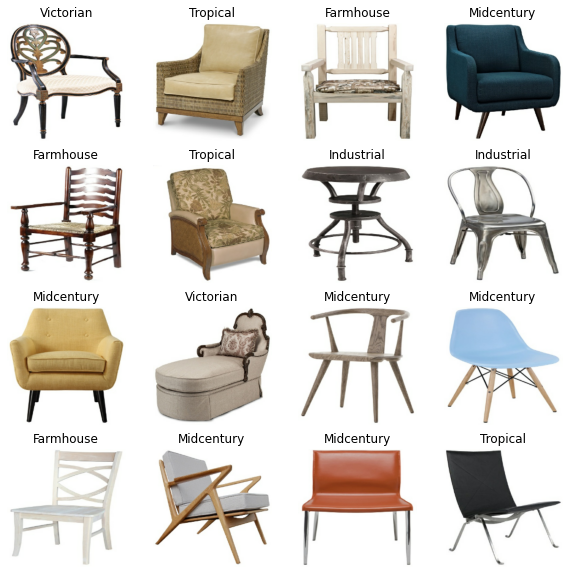

In [7]:
#look at the dataset

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
    plt.title(class_names[labels[i]])
    plt.axis("off")

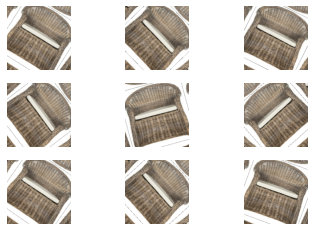

In [8]:
#from tensorflow.keras.layers.experimental import preprocessing
#from tensorflow.keras.models import Sequential
img_augmentation = keras.Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomFlip("horizontal"),
       # preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
       # preprocessing.RandomFlip(),
       # preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)


for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(image)
        # aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
#        plt.title(int(labels[i]))
#       plt.title("{}".format(format_label(label)))
        plt.axis("off")

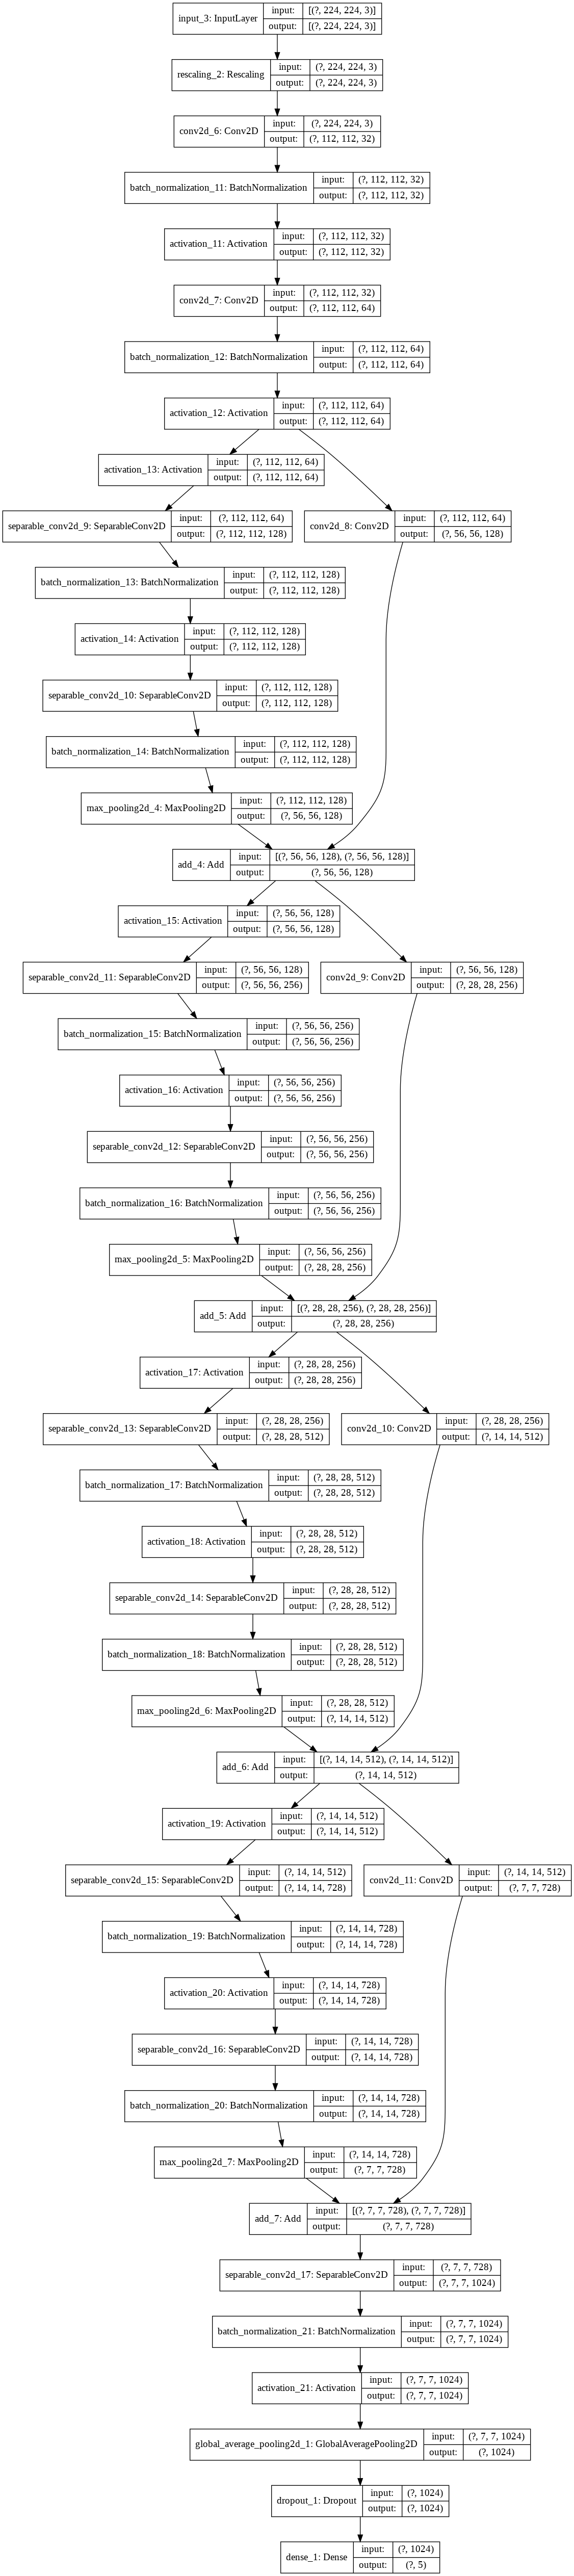

In [13]:
image_size = (img_height, img_width)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    #x = img_augmentation(input)
    x = inputs

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 1, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)
keras.utils.plot_model(model, show_shapes=True)


In [14]:
ds_train = ds_train.prefetch(buffer_size=32) 
ds_valid = ds_valid.prefetch(buffer_size=32)

In [17]:
epochs = 10
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),
    #loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    ds_train, epochs=epochs, callbacks=callbacks, validation_data=ds_valid,
)

Epoch 1/10
96/96 [==============================] - 19s 195ms/step - loss: 1.2949 - accuracy: 0.4893 - val_loss: 4.1062 - val_accuracy: 0.3118
Epoch 2/10
96/96 [==============================] - 19s 196ms/step - loss: 1.0633 - accuracy: 0.5844 - val_loss: 3.9728 - val_accuracy: 0.3000
Epoch 3/10
96/96 [==============================] - 19s 193ms/step - loss: 0.9155 - accuracy: 0.6554 - val_loss: 2.1365 - val_accuracy: 0.4353
Epoch 4/10
96/96 [==============================] - 18s 191ms/step - loss: 0.8678 - accuracy: 0.6684 - val_loss: 0.9288 - val_accuracy: 0.6529
Epoch 5/10
96/96 [==============================] - 18s 192ms/step - loss: 0.7960 - accuracy: 0.7147 - val_loss: 2.4709 - val_accuracy: 0.4059
Epoch 6/10
96/96 [==============================] - 19s 194ms/step - loss: 0.7028 - accuracy: 0.7472 - val_loss: 1.9087 - val_accuracy: 0.3941
Epoch 7/10
96/96 [==============================] - 18s 192ms/step - loss: 0.6516 - accuracy: 0.7583 - val_loss: 3.9522 - val_accuracy: 0.3941